In [17]:
from bloqade import start, var, save, load
from bloqade.atom_arrangement import Chain
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_notebook
import os
output_notebook()

if not os.path.isdir("data"):
    os.mkdir("data")

n_atoms = 5
lattice_spacing = 7
run_time = var("run_time")
C6 = 2*np.pi * 862690;
omega_max = C6/(lattice_spacing*np.sqrt(np.sqrt(2)))**6
print(omega_max)
flipfloptime = 0.2

atom_coord = [(0,0), (0,lattice_spacing), (0,2*lattice_spacing),\
              (lattice_spacing, 0), (lattice_spacing, lattice_spacing), (lattice_spacing, 2*lattice_spacing),\
              (2*lattice_spacing, 0), (2*lattice_spacing, lattice_spacing), (2*lattice_spacing, 2*lattice_spacing),\
             ]

quantum_scar_program = (
    start.add_position(atom_coord)
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        [0.3, 1.3, 0.3], [-18.8, -18.8, omega_max*2, omega_max*2]
    )
    .piecewise_linear([flipfloptime, 0.3, 0.2, 3], [omega_max*2, 0, omega_max*2, omega_max*2, 0.0])
    # .piecewise_linear([flipfloptime, 0.2, 0.2, 3], [0, omega_max*2, omega_max*2, 0, 0])
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    
    # define rabi waveform
    .amplitude.uniform.piecewise_linear([0.3, 1.3, 0.3], [0.0, omega_max, omega_max, 0.0])
    .piecewise_linear([flipfloptime, 0.1,0.1,3], [0, omega_max, omega_max,0, 0])
    # .piecewise_linear([flipfloptime, 0.1,0.1,14], [0, omega_max, omega_max,0, 0])
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

# get run times via the following:
prep_times = np.arange(0.2, 2.2, 0.5)
scar_times = np.arange(2.2, 4, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times)

emu_batch = batch.bloqade.python().run(1000)
emu_batch.report().show()

Loading BokehJS ...

16.28926162534252


In [18]:
def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("010101010", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

def get_z1_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("101010101", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

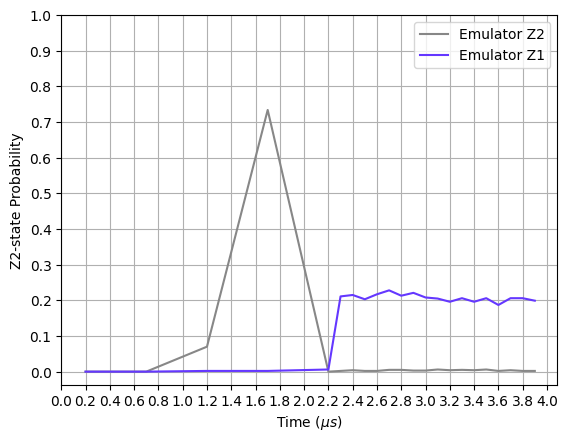

In [19]:
emu_report = emu_batch.report()
#hardware_report = hardware_batch.report()

emu_run_times = emu_report.list_param("run_time")
emu_z2_prob = get_z2_probabilities(emu_report)
emu_z1_prob = get_z1_probabilities(emu_report)

#hw_run_times = hardware_report.list_param("run_time")
#hw_z2_prob = get_z2_probabilities(hardware_report)

plt.plot(emu_run_times, emu_z2_prob, label="Emulator Z2", color="#878787")
plt.plot(emu_run_times, emu_z1_prob, label="Emulator Z1", color="#6437FF")
#plt.plot(hw_run_times, hw_z2_prob, label="QPU", color="#6437FF")

plt.legend()
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Z2-state Probability")
plt.xticks(np.arange(0, 4.2, step=0.2))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid()
plt.show()

In [60]:
max_omega = 15.7
C6 = 2*np.pi * 862690;
Rb = (C6 / (max_omega) )** (1/6) # R_B during bulk of protocol
print(Rb)
print("Rb/a: ",Rb/lattice_spacing)
delta_end = 16.3
print("Delta/Omega: ", delta_end/max_omega)

8.375726676214509
Rb/a:  1.1965323823163583
Delta/Omega:  1.0382165605095541


In [61]:
print(C6/(7*np.sqrt(np.sqrt(2)))**6)

16.28926162534252


In [ ]:
Notes:
    Decreasing delta and omega after preparing the inital state
    leads to the creation of the inverse, decreasing the delta and 
    omega values to be negative in a short pulse helps "merge"
    states that are highly probable but are orthogonal
    Inserting a brief negative pulse seems to be the key, just need to
    keep it short
    The idea is to allow for "relaxation" of the state by reducing the 
    rydberg blockade